## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`,
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [1]:
import pandas as pd
import numpy as np
import os
import glob

In [2]:
df_car_data = pd.read_csv('car-price_data.csv')
print(df_car_data.columns)

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


In [3]:
df_car_data= df_car_data[['Make', 'Model', 'Year','Engine HP',
       'Engine Cylinders', 'Transmission Type',  'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']]
df_car_data.columns = df_car_data.columns.str.replace(' ', '_').str.lower()
print(df_car_data.columns)
print(df_car_data.dtypes)

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')
make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
msrp                   int64
dtype: object


In [4]:
df_car_data.isnull().sum()  # engine_hp and engine_cylinders have 69 and 30 null values respectively

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [5]:
# Imputuing missing values with 0
df_car_data.engine_cylinders = df_car_data.engine_cylinders.fillna(0)
df_car_data.engine_hp = df_car_data.engine_hp.fillna(0)


In [7]:
mean_val = df_car_data['msrp'].mean()
df_car_data['above_average'] = np.where(df_car_data['msrp'] > mean_val, 1, 0)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df_car_data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [15]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [19]:
#column_name = 'engine_hp'
for column_name in ['engine_hp','engine_cylinders','highway_mpg','city_mpg']:
    print("column:", column_name)
    y_mean_val = df_train[column_name].mean()
    if column_name in ['engine_hp','engine_cylinders']:
        y_pred = np.where(df_train[column_name] > y_mean_val, 1, 0)
    else:
        y_pred = np.where(df_train[column_name] < y_mean_val, 1, 0)
       
    y_train = df_train.above_average
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    print("auc score:",auc(fpr, tpr))

column: engine_hp
auc score: 0.8115551356788278
column: engine_cylinders
auc score: 0.696902522069401
column: highway_mpg
auc score: 0.6041996543409193
column: city_mpg
auc score: 0.6198186250811294


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [20]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [21]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

categorical = df_train.select_dtypes(include=[object]).columns.tolist()

numerical = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [22]:
from sklearn.linear_model import LogisticRegression

In [28]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [29]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [30]:
y_pred_val = model.predict_proba(X_val)[:, 1]
y_pred_val = y_pred_val>0.5

In [31]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
print("auc score:",auc(fpr, tpr))

auc score: 0.9133264530415665


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [44]:


thresholds = np.linspace(0, 1, 101)
scores =[]
y_pred_val = model.predict_proba(X_val)[:, 1]
for t in thresholds:
    y_pred = y_pred_val > t
    #print("threshold:",t)
    #print("precision:",precision_score(y_val, y_pred))
    #print("f1 score:",f1_score(y_val, y_pred))
    pre = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    scores.append((t, pre, rec,f1))

columns = ['threshold', 'precision','recall','f1_score']
df_scores = pd.DataFrame(scores, columns=columns)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
df_scores

,threshold,precision,recall
0,0.00,0.274444,1.000000
1,0.01,0.461103,0.996942
2,0.02,0.507009,0.995413
3,0.03,0.540698,0.995413
4,0.04,0.570175,0.993884
...,...,...,...
96,0.96,0.996454,0.429664
97,0.97,0.996241,0.405199
98,0.98,1.000000,0.363914
99,0.99,1.000000,0.308869


In [39]:
import matplotlib.pyplot as plt

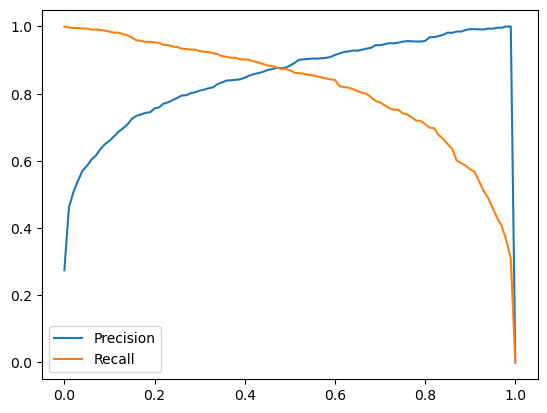

In [43]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [45]:
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]

,threshold,precision,recall,f1_score
52,0.52,0.9008,0.860856,0.880375


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [47]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [48]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [58]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [52]:
df_full_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg', 'msrp',
       'above_average'],
      dtype='object')

In [59]:
n_splits = 5
C= 1.0
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    df_train.drop('above_average', axis=1, inplace=True)
    df_val.drop('above_average', axis=1, inplace=True)
    df_train.drop('msrp', axis=1, inplace=True)
    df_val.drop('msrp', axis=1, inplace=True)
    
    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)
    y_pred_val = y_pred>0.5
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    auc_val = auc(fpr, tpr)
    scores.append(auc_val)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C:\Users\Alvi\AppData\Local\Temp\ipykernel_5672\1689678052.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('above_average', axis=1, inplace=True)
C:\Users\Alvi\AppData\Local\Temp\ipykernel_5672\1689678052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop('above_average', axis=1, inplace=True)
C:\Users\Alvi\AppData\Local\Temp\ipykernel_5672\1689678052.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C=1.0 0.916 +- 0.011


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.916 +- 0.011


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [64]:
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [66]:
n_splits = 5

for C in tqdm.tqdm([ 0.01, 0.1, 0.5, 10]):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        df_train.drop('above_average', axis=1, inplace=True)
        df_val.drop('above_average', axis=1, inplace=True)
        df_train.drop('msrp', axis=1, inplace=True)
        df_val.drop('msrp', axis=1, inplace=True)
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        y_pred_val = y_pred>0.5
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
        auc_val = auc(fpr, tpr)
        scores.append(auc_val)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
        

 25%|██▌       | 1/4 [00:07<00:21,  7.17s/it]

C=0.01 0.843 +- 0.003


 50%|█████     | 2/4 [00:43<00:48, 24.36s/it]

C=0.1 0.891 +- 0.006
